In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import p5lib

%matplotlib inline

In [3]:
data = pd.read_csv('MERGED2013_PP.csv')
print "Number of features: {}".format(len(data.columns))
print "Number of rows: {}".format(len(data))

Number of features: 1729
Number of rows: 7804


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7,9,1427,1542,1561,1575,1725,1726,1727,1728) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = p5lib.preprocess_data(data)
print "Num data after preprocessing: {}".format(len(data))
print "Num features: {}".format(len(data.columns))
# print data.shape


Num data after preprocessing: 6007
Num features: 45


In [5]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'C150', 'RET_FT']].dropna()
y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape

# print X.PFTFTUG1_EF.describe()

(1210, 25)
(1210, 2)


In [6]:
from sklearn import preprocessing

tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A']]

scaler = preprocessing.MinMaxScaler()
scaledX = scaler.fit_transform(tmpX)

# print np.array(tmpX.ix[0])
# print scaledX[0]

# X_for_PCA = pd.DataFrame(scaledX)
pctX = X[['PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL']]
pctX = np.array(pctX)

forPcaX = np.concatenate((scaledX, pctX), axis=1)
# print scaledX.shape
# print pctX.shape
print forPcaX.shape


(1210, 23)


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=forPcaX.shape[1])
pca.fit(forPcaX)

# print pca.components_
print pca.explained_variance_ratio_


[  3.16257628e-01   1.73164702e-01   1.12819213e-01   7.91939545e-02
   7.80674005e-02   6.51524359e-02   3.85663143e-02   2.91864611e-02
   2.18495298e-02   1.80977204e-02   1.31349331e-02   1.03917544e-02
   1.01671138e-02   8.62855457e-03   7.64238311e-03   5.54657921e-03
   3.96454892e-03   3.27242079e-03   2.96323839e-03   1.27343293e-03
   6.59681299e-04   1.85675207e-19   9.47273654e-20]


In [8]:
pca = PCA(n_components=12)
pca.fit(forPcaX)
reducedX = pca.transform(forPcaX)
print reducedX.shape

(1210, 12)


In [9]:
# add the categorical feature

tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 
print tmp1X.shape
print tmp2X.shape
print reducedX.shape
finalX = np.concatenate((reducedX, tmp1X, tmp2X), axis=1)
print finalX.shape

(1210, 3)
(1210, 1)
(1210, 12)
(1210, 16)


In [10]:
from sklearn import metrics
from sklearn import cross_validation as cv
from sklearn.tree import DecisionTreeRegressor

y = np.array(y)
X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(968, 16)
(242, 16)
(968, 2)
(242, 2)


--- Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 10.0, 'gamma': 0.10000000000000001}
R2 score on train data: 0.844314833076
R2 score on test  data: 0.815770656664
--- Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 10.0, 'gamma': 0.10000000000000001}
R2 score on train data: 0.713789455946
R2 score on test  data: 0.702687362857


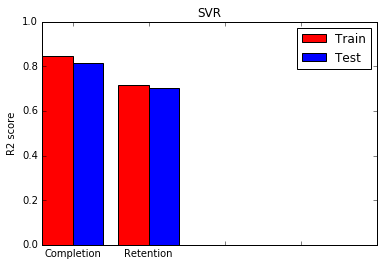

In [11]:
SVR_reg1, SVR_reg2, _, _ = p5lib.build_SVR_model(X_train, X_test, y_train, y_test, cv=3)

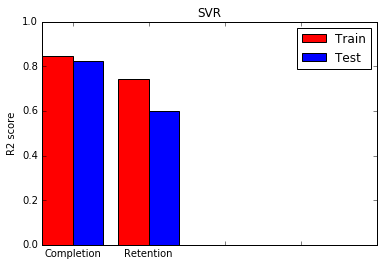

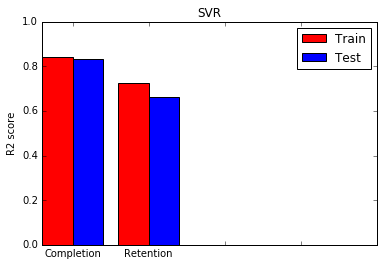

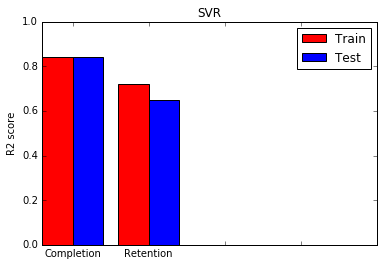

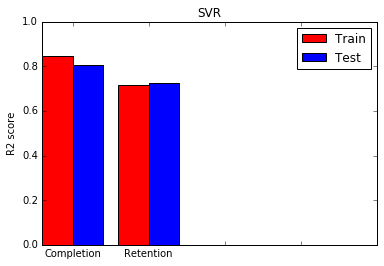

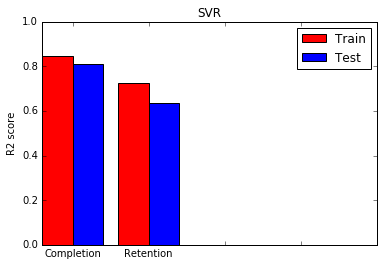

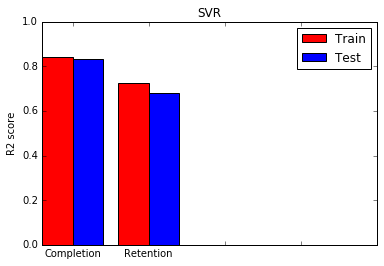

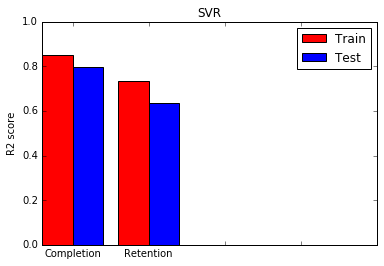

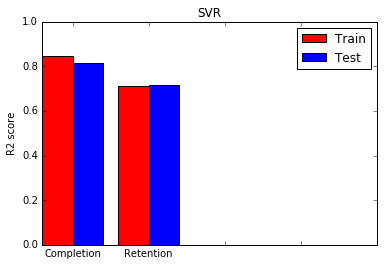

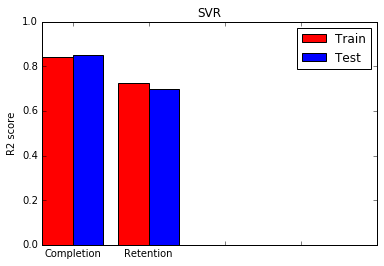

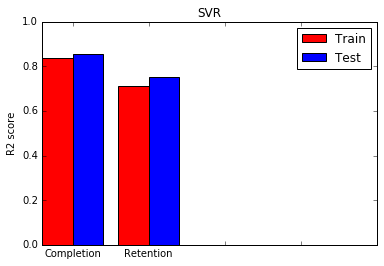

Completion
{'max': 0.85430129308084735, 'min': 0.79502760681199958, 'mean': 0.82547660702202985}
Retention
{'max': 0.75384073189788003, 'min': 0.59860506843025152, 'mean': 0.67476556791273468}


In [12]:
import StringIO
import os

reg1_r2scores = []
reg2_r2scores = []

for i in range(0, 10):
    # suppress output
    actualstdout = sys.stdout
    sys.stdout = open(os.devnull,'w')

    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    SVR_reg1, SVR_reg2, r2score_reg1, r2score_reg2 = p5lib.build_SVR_model(X_train, X_test, y_train, y_test, cv=3)
    reg1_r2scores.append(r2score_reg1)
    reg2_r2scores.append(r2score_reg2)
    
    sys.stdout = actualstdout

reg1_r2scores = pd.Series(reg1_r2scores)
reg2_r2scores = pd.Series(reg2_r2scores)
print 'Completion'
print { 'mean': reg1_r2scores.mean(), 'min': reg1_r2scores.min(), 'max': reg1_r2scores.max()}
print 'Retention'
print { 'mean': reg2_r2scores.mean(), 'min': reg2_r2scores.min(), 'max': reg2_r2scores.max()}

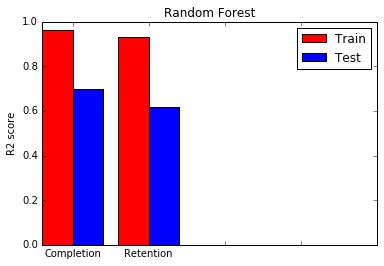

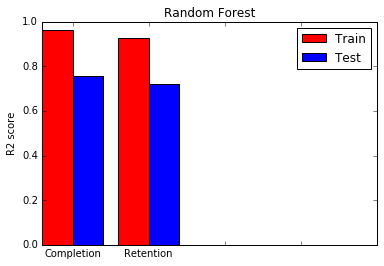

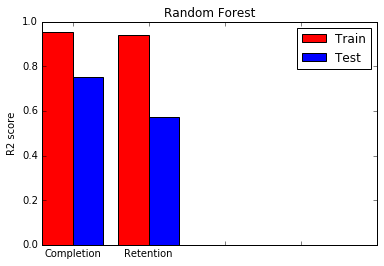

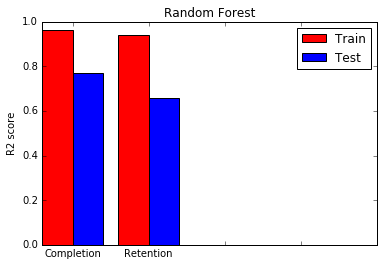

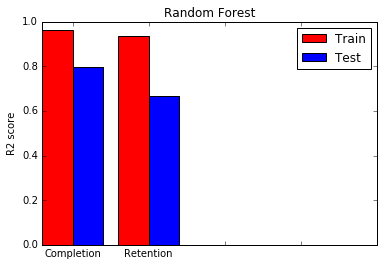

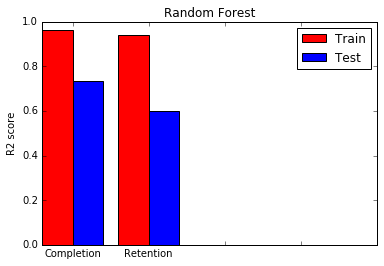

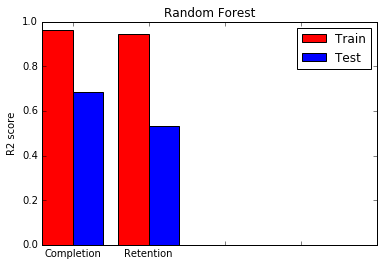

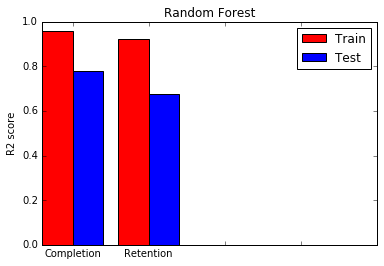

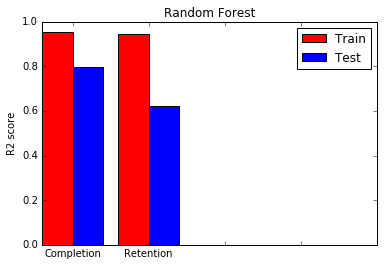

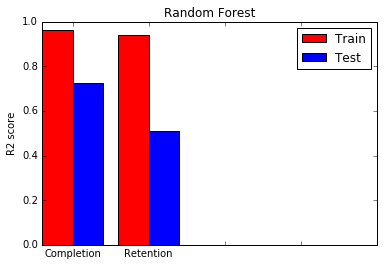

{'max': 0.79610743276148366, 'min': 0.68356900701990031, 'mean': 0.74892112072768269}
{'max': 0.7182244877704681, 'min': 0.508466645104655, 'mean': 0.61688651881098588}


In [13]:
import StringIO
import os

reg1_r2scores = []
reg2_r2scores = []

for i in range(0, 10):
    # suppress output
    actualstdout = sys.stdout
    sys.stdout = open(os.devnull,'w')

    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    RForest_reg1, RForest_reg2, r2score_reg1, r2score_reg2 = p5lib.build_RandomForest_model(X_train, X_test, y_train, y_test)
    reg1_r2scores.append(r2score_reg1)
    reg2_r2scores.append(r2score_reg2)
    
    sys.stdout = actualstdout

reg1_r2scores = pd.Series(reg1_r2scores)
reg2_r2scores = pd.Series(reg2_r2scores)
print { 'mean': reg1_r2scores.mean(), 'min': reg1_r2scores.min(), 'max': reg1_r2scores.max()}
print { 'mean': reg2_r2scores.mean(), 'min': reg2_r2scores.min(), 'max': reg2_r2scores.max()}

--- Completion ---
best params: {'max_depth': 4}
R2 score on train data: 0.786220777877
R2 score on test  data: 0.633426268814
--- Retention ---
best params: {'max_depth': 4}
R2 score on train data: 0.636944286244
R2 score on test  data: 0.385442075177


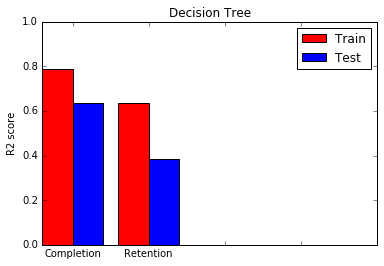

In [14]:
DT_reg1, DT_reg2, _, _ = p5lib.build_DecisionTree_model(X_train, X_test, y_train, y_test)

--- Completion ---
best params: {'n_neighbors': 9}
R2 score on train data: 0.82865882823
R2 score on test  data: 0.724355371347
--- Retention ---
best params: {'n_neighbors': 8}
R2 score on train data: 0.749843484465
R2 score on test  data: 0.547205995785


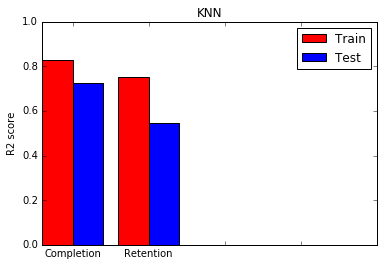

In [15]:
KNN_reg1, KNN_reg2, _, _ = p5lib.build_KNN_model(X_train, X_test, y_train, y_test)

--- Completion ---
R2 score on train data: 0.972814987418
R2 score on test  data: 0.745001678227
--- Retention ---
R2 score on train data: 0.956660285582
R2 score on test  data: 0.547749698442


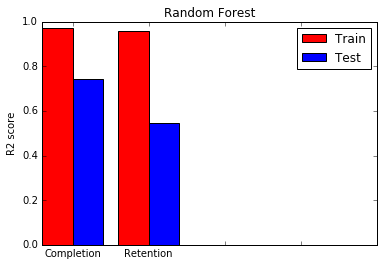

In [16]:
RForest_reg1, RForest_reg2, _, _ = p5lib.build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=300)

In [17]:
from sklearn import ensemble

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
reg1 = ensemble.GradientBoostingRegressor(**params)

y1_train, y1_test, y2_train, y2_test = p5lib.split_y(y_train, y_test)

reg1.fit(X_train, y1_train)
# print reg.best_params_
print metrics.r2_score(y1_test, reg1.predict(X_test))


reg2 = ensemble.GradientBoostingRegressor(**params)


reg2.fit(X_train, y2_train)
# print reg.best_params_
print metrics.r2_score(y2_test, reg2.predict(X_test))

0.720565784151
0.541866639267
